In [4]:
!python -m pip install pandas openpyxl matplotlib

     |████████████████████████████████| 242 kB 811 kB/s            


In [2]:
import pandas as pd

In [3]:
df = pd.read_excel("data/Biertoto.xlsx")

In [4]:
df

,Heim,Gast,Htore,Gtore,UHT,UGT,SHT,SGT,Spieltag,Saison,Unnamed: 10,UP,SP,Spieltag.1,Unnamed: 14
0,SC Freiburg,Borussia Mönchengladbach,0.0,0.0,1.0,2.0,1.0,0.0,18,95/96,1.0,0.0,0.0,NaN,NaN
1,1. FC Kaiserslautern,Borussia Dortmund,1.0,1.0,0.0,4.0,0.0,1.0,18,95/96,2.0,0.0,0.0,NaN,NaN
2,TSV 1860 München,FC St. Pauli,2.0,0.0,2.0,1.0,2.0,1.0,18,95/96,3.0,1.0,1.0,NaN,NaN
3,Karlsruher SC,Eintracht Frankfurt,1.0,1.0,2.0,0.0,0.0,2.0,18,95/96,4.0,0.0,0.0,NaN,NaN
4,Hamburger SV,Bayern München,2.0,1.0,1.0,3.0,1.0,2.0,18,95/96,5.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,21/22,8105.0,NaN,NaN,NaN,NaN
8105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,21/22,8106.0,NaN,NaN,NaN,NaN
8106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,21/22,8107.0,NaN,NaN,NaN,NaN
8107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,21/22,8108.0,NaN,NaN,NaN,NaN


In [5]:
df = df.dropna(subset=['Heim']).copy()

In [6]:
def home_draw_away_generic(home_goals, away_goals)->str:
    """
    A = away team won
    H = home team won
    D = draw
    """
    diff = home_goals - away_goals
    if diff < 0:
        return 'A'
    elif diff > 0:
        return 'H'
    else:
        return 'D'


In [7]:
def home_draw_away(row):
    return home_draw_away_generic(row['Htore'], row['Gtore'])
    

In [8]:
def home_draw_away_uwe(row):
    return home_draw_away_generic(row['UHT'], row['UGT'])

In [9]:
def home_draw_away_schadix(row):
    return home_draw_away_generic(row['SHT'], row['SGT'])

In [10]:
def match_result_generic(home_goals_1, away_goals_1, home_goals_2, away_goals_2)->bool:
    try:
        return int(home_goals_1) == int(home_goals_2) and int(away_goals_1) == int(away_goals_2)
    except ValueError:
        return False

    

In [11]:
def same_goal_difference(home_goals_1, away_goals_1, home_goals_2, away_goals_2)->bool:
    try:
        return int(home_goals_1) - int(away_goals_1) == int(home_goals_2) - int(away_goals_2)
    except ValueError:
        return False

    

In [12]:
def same_goal_difference_uwe(row)->bool:
    return same_goal_difference(home_goals_1=row['UHT'], 
                                  away_goals_1=row['UGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

In [13]:
def same_goal_difference_schadix(row)->bool:
    return same_goal_difference(home_goals_1=row['SHT'], 
                                  away_goals_1=row['SGT'],
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

In [14]:
def same_result_uwe(row)->bool:
    return match_result_generic(home_goals_1=row['UHT'], 
                                  away_goals_1=row['UGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

In [15]:
def same_result_schadix(row)->bool:
    return match_result_generic(home_goals_1=row['SHT'], 
                                  away_goals_1=row['SGT'], 
                                  home_goals_2=row['Htore'], 
                                  away_goals_2=row['Gtore'])

In [16]:
def get_year(row)->int:
    """add 19 to string with split on / in case of 9x else add 20"""
    saison = row['Saison']
    first_year, second_year = saison.split('/')
    first_year = first_year.strip()
    if first_year.startswith('9'):
        return int("19"+first_year)
    else:
        return int("20"+first_year)
        

In [17]:
def calculate_points_generic(tendency:bool=False, 
                             same_goal_difference:bool=False, 
                             same_result:bool=False)->int:
    result_points = 0
    if tendency:
        result_points += 2
    if same_goal_difference:
        result_points += 1
    if same_result:
        result_points += 1
    return result_points
    

In [18]:
df['year'] = df.apply(get_year, axis=1)

In [19]:
df['tendenz'] = df.apply(home_draw_away, axis=1)

In [20]:
df['tendenz_uwe'] = df.apply(home_draw_away_uwe, axis=1)

In [21]:
df['tendenz_schadix'] = df.apply(home_draw_away_schadix, axis=1)

In [22]:
df['same_goal_uwe'] = df.apply(same_goal_difference_uwe, axis=1)

In [23]:
df['same_goal_schadix'] = df.apply(same_goal_difference_schadix, axis=1)

In [24]:
df['same_result_uwe'] = df.apply(same_result_uwe, axis=1)

In [25]:
df['same_result_schadix'] = df.apply(same_result_schadix, axis=1)

In [26]:
df['result_match_uwe_schadix'] = df.apply(lambda row: match_result_generic(row['UHT'], row['UGT'], row['SHT'], row['SGT']), axis=1)

In [27]:
df['points_uwe'] = df.apply(lambda row: calculate_points_generic(tendency=row['tendenz_uwe']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_uwe'],
                                                                 same_result=row['same_result_uwe']
                                                                ), axis=1)

In [28]:
df['points_schadix'] = df.apply(lambda row: calculate_points_generic(tendency=row['tendenz_schadix']==row['tendenz'],
                                                                 same_goal_difference=row['same_goal_schadix'],
                                                                 same_result=row['same_result_schadix']
                                                                ), axis=1)

In [29]:
df = df.set_index('year')

In [30]:
df

,Heim,Gast,Htore,Gtore,UHT,UGT,SHT,SGT,Spieltag,Saison,...,tendenz,tendenz_uwe,tendenz_schadix,same_goal_uwe,same_goal_schadix,same_result_uwe,same_result_schadix,result_match_uwe_schadix,points_uwe,points_schadix
year,,,,,,,,,,,,,,,,,,,,,
1995,SC Freiburg,Borussia Mönchengladbach,0.0,0.0,1.0,2.0,1.0,0.0,18,95/96,...,D,A,H,False,False,False,False,False,0,0
1995,1. FC Kaiserslautern,Borussia Dortmund,1.0,1.0,0.0,4.0,0.0,1.0,18,95/96,...,D,A,A,False,False,False,False,False,0,0
1995,TSV 1860 München,FC St. Pauli,2.0,0.0,2.0,1.0,2.0,1.0,18,95/96,...,H,H,H,False,False,False,False,True,2,2
1995,Karlsruher SC,Eintracht Frankfurt,1.0,1.0,2.0,0.0,0.0,2.0,18,95/96,...,D,H,A,False,False,False,False,False,0,0
1995,Hamburger SV,Bayern München,2.0,1.0,1.0,3.0,1.0,2.0,18,95/96,...,H,A,A,False,False,False,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,Bayer 04 Leverkusen,VfL Wolfsburg,0.0,2.0,3.0,1.0,2.0,0.0,10,21/22,...,A,H,H,False,False,False,False,False,0,0
2021,Borussia Dortmund,1. FC Köln,2.0,0.0,3.0,1.0,3.0,1.0,10,21/22,...,H,H,H,True,True,False,False,True,3,3
2021,Eintracht Frankfurt,RB Leipzig,1.0,1.0,1.0,3.0,0.0,3.0,10,21/22,...,D,A,A,False,False,False,False,False,0,0


In [31]:
df_points_sum = df.groupby('year').sum(['points_schadix', 'points_uwe'])[['points_schadix', 'points_uwe']]

In [32]:
df_points_sum

,points_schadix,points_uwe
year,,
1995,131,146
1996,357,372
1997,322,356
1998,338,394
1999,375,372
2000,316,375
2001,344,389
2002,325,371
2003,422,365


### Gesamtpunkte im Laufe der Zeit

<AxesSubplot:xlabel='year'>

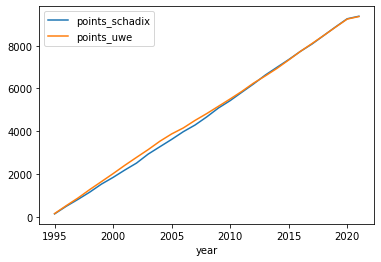

In [33]:
df_points_sum.cumsum().plot()

In [34]:
df_same_tipps_over_time = df.groupby('year').sum(['result_match_uwe_schadix'])[['result_match_uwe_schadix']]

### Wie haeufig gleiche Ergebnisse getippt im Laufe der Zeit

<AxesSubplot:xlabel='year'>

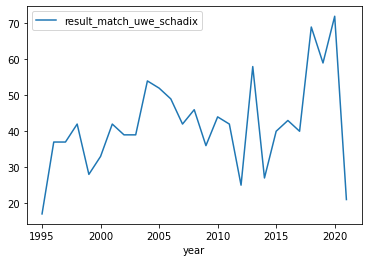

In [35]:
df_same_tipps_over_time.plot()

In [41]:
df['same_tendenz'] = df.apply(lambda row: row['tendenz_uwe'] == row['tendenz_schadix'], axis=1)

In [43]:
df_same_tendenz = df.groupby('year').sum(['same_tendenz'])[['same_tendenz']]

<AxesSubplot:xlabel='year'>

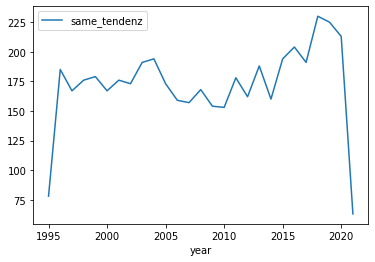

In [44]:
df_same_tendenz.plot()

In [50]:
df_same_tendenz['avg_3'] = df_same_tendenz.same_tendenz.rolling(3, min_periods=0).mean()

In [51]:
df_same_tendenz['avg_5'] = df_same_tendenz.same_tendenz.rolling(5, min_periods=0).mean()

<AxesSubplot:xlabel='year'>

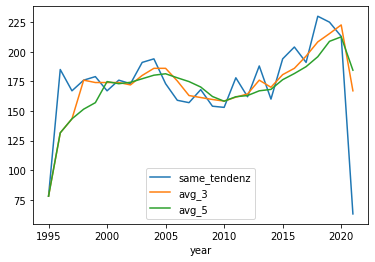

In [52]:
df_same_tendenz.plot()